# CVInsight Concurrent Analysis Demo

This notebook demonstrates CVInsight's advanced parallel processing capabilities for high-performance resume analysis. Perfect for understanding concurrency benefits and optimizing processing pipelines.

## 🚀 What You'll Learn
- **Parallel vs Sequential Processing**: Performance comparisons with real metrics
- **Scalability Testing**: How performance scales with resume count
- **Concurrency Optimization**: Tuning workers and batch sizes
- **Production Integration**: Best practices for concurrent processing in applications

## 🎯 Use Cases
- High-volume recruitment processing
- Real-time candidate screening
- Batch job optimization
- Performance benchmarking

## 📋 Integration from External Repository
```bash
# 1. Clone CVInsight
git clone https://github.com/your-username/CVInsight.git

# 2. Install dependencies  
pip install -r CVInsight/requirements.txt

# 3. Set API key
export OPEN_AI_API_KEY="your-key-here"

# 4. Run this notebook from your own repository
```

In [1]:
# Setup and Imports
import os
import sys
import time
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict

# Add CVInsight to Python path (adjust for your external repository setup)
CVINSIGHT_PATH = "/Users/samcelarek/Documents/CVInsight"
if CVINSIGHT_PATH not in sys.path:
    sys.path.insert(0, CVINSIGHT_PATH)

try:
    from cvinsight.notebook_utils import (
        initialize_client,
        find_resumes,
        parse_single_resume,
        parse_many_resumes
    )
    print("✅ CVInsight successfully imported")
    print(f"📁 CVInsight path: {CVINSIGHT_PATH}")
except ImportError as e:
    print(f"❌ Error importing CVInsight: {e}")
    print("Please ensure CVInsight is cloned and available at the specified path")
    raise

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

✅ CVInsight successfully imported
📁 CVInsight path: /Users/samcelarek/Documents/CVInsight


In [2]:
# Initialize CVInsight Client
print("🔧 INITIALIZING CVINSIGHT CLIENT")
print("=" * 50)

# Get API key
api_key = os.environ.get("OPEN_AI_API_KEY")
if not api_key:
    print("🔑 OpenAI API key not found in environment")
    api_key = input("Enter your OpenAI API key: ")

# Initialize client
client = initialize_client(api_key=api_key)

# Verify extractors
extractors = list(client._plugin_manager.extractors.keys())
print(f"📦 Available extractors: {len(extractors)}")
print(f"🔗 Unified extractor available: {'extended_analysis_extractor' in extractors}")

if 'extended_analysis_extractor' not in extractors:
    raise RuntimeError("Unified extractor not available!")

print("✅ Client initialized and ready for concurrent processing")

🔧 INITIALIZING CVINSIGHT CLIENT
📦 Available extractors: 6
🔗 Unified extractor available: True
✅ Client initialized and ready for concurrent processing


In [3]:
# Resume Discovery and Job Setup
print("\n📁 RESUME DISCOVERY")
print("=" * 30)

# Find resumes (adjust path for your setup)
resume_dir = "/Users/samcelarek/Documents/CVInsight/Resumes"
resumes = find_resumes(resume_dir)
print(f"Found {len(resumes)} resumes in directory")

if len(resumes) < 5:
    print("⚠️  Warning: Less than 5 resumes found. Concurrent benefits are more visible with larger datasets.")

# Show sample resumes
print("\n📄 Sample resumes:")
for i, resume in enumerate(resumes[:5], 1):
    print(f"  {i}. {os.path.basename(resume)}")
if len(resumes) > 5:
    print(f"  ... and {len(resumes) - 5} more")

# Define comprehensive job description
job_description = """
Senior Software Engineer - AI/ML Platform

We're seeking an experienced Senior Software Engineer to join our AI/ML platform team:

Required Skills:
- 5+ years of software engineering experience
- Strong proficiency in Python, Java, or Go
- Experience with machine learning frameworks (TensorFlow, PyTorch, scikit-learn)
- Cloud platforms (AWS, GCP, Azure) and containerization (Docker, Kubernetes)
- Database design and optimization (SQL and NoSQL)
- API design and microservices architecture

Preferred Qualifications:
- Master's degree in Computer Science, Engineering, or related field
- Experience with MLOps and model deployment pipelines
- Knowledge of distributed systems and big data technologies
- Leadership experience and mentoring capabilities
- Open source contributions

This role involves building scalable ML infrastructure, collaborating with data scientists, 
and leading technical initiatives in our growing AI platform.
"""

print(f"\n📋 Job description loaded ({len(job_description)} characters)")
print("🎯 Focus: Senior Software Engineer - AI/ML Platform")


📁 RESUME DISCOVERY
Found 21 resumes in directory

📄 Sample resumes:
  1. 2023-08-28 - Wesley Ordonez Resume Wesley Ordonez 2023 (Data Analytics).pdf
  2. 2023-08-20 - Weihao Chen Resume Resume_Weihao Chen.pdf
  3. 2023-08-26 - Akhil Bukkapuram Resume Akhil_ds.pdf
  4. 2023-08-28 - Brian Warras Resume BrianWarras.pdf
  5. 2023-08-22 - Stefani Sanchez Resume Stefani Sanchez Resume.pdf
  ... and 16 more

📋 Job description loaded (941 characters)
🎯 Focus: Senior Software Engineer - AI/ML Platform


In [ ]:
# Performance Benchmarking: Sequential vs Parallel
print("\n⚡ PERFORMANCE BENCHMARKING")
print("=" * 50)

# Test with different batch sizes for comprehensive analysis
test_sizes = [3, 5, 8] if len(resumes) >= 8 else [min(3, len(resumes))]
results_comparison = []

for batch_size in test_sizes:
    print(f"\n🔄 Testing with {batch_size} resumes:")
    test_resumes = resumes[:batch_size]
    
    # Sequential Processing
    print("  📊 Sequential processing...")
    start_time = time.time()
    df_sequential = parse_many_resumes(
        client=client,
        resume_paths=test_resumes,
        date_of_resume_submission="2025-05-29",
        job_description=job_description,
        parallel=False,
        use_tqdm=True
    )
    sequential_time = time.time() - start_time
    
    # Parallel Processing
    print("  ⚡ Parallel processing...")
    start_time = time.time()
    df_parallel = parse_many_resumes(
        client=client,
        resume_paths=test_resumes,
        date_of_resume_submission="2025-05-29",
        job_description=job_description,
        parallel=True,
        use_tqdm=True
    )
    parallel_time = time.time() - start_time
    
    # Calculate metrics
    speedup = sequential_time / parallel_time if parallel_time > 0 else 1
    sequential_rate = batch_size / sequential_time * 60  # resumes per minute
    parallel_rate = batch_size / parallel_time * 60
    
    results_comparison.append({
        'batch_size': batch_size,
        'sequential_time': sequential_time,
        'parallel_time': parallel_time,
        'speedup': speedup,
        'sequential_rate': sequential_rate,
        'parallel_rate': parallel_rate,
        'sequential_success': len(df_sequential[df_sequential['parsing_status'] == 'success']),
        'parallel_success': len(df_parallel[df_parallel['parsing_status'] == 'success'])
    })
    
    print(f"    Sequential: {sequential_time:.2f}s ({sequential_rate:.1f} resumes/min)")
    print(f"    Parallel:   {parallel_time:.2f}s ({parallel_rate:.1f} resumes/min)")
    print(f"    Speedup:    {speedup:.2f}x faster")

# Store the last (largest) dataset for detailed analysis
final_df = df_parallel
print(f"\n✅ Benchmarking complete! Using {len(final_df)} resumes for detailed analysis.")


⚡ PERFORMANCE BENCHMARKING

🔄 Testing with 3 resumes:
  📊 Sequential processing...


Parsing resumes: 100%|██████████| 3/3 [01:09<00:00, 23.22s/it]


  ⚡ Parallel processing...


Parsing resumes: 100%|██████████| 3/3 [00:22<00:00,  7.62s/it]


    Sequential: 69.68s (2.6 resumes/min)
    Parallel:   22.87s (7.9 resumes/min)
    Speedup:    3.05x faster

🔄 Testing with 5 resumes:
  📊 Sequential processing...


Parsing resumes:   0%|          | 0/5 [00:00<?, ?it/s]


📊 PERFORMANCE VISUALIZATION


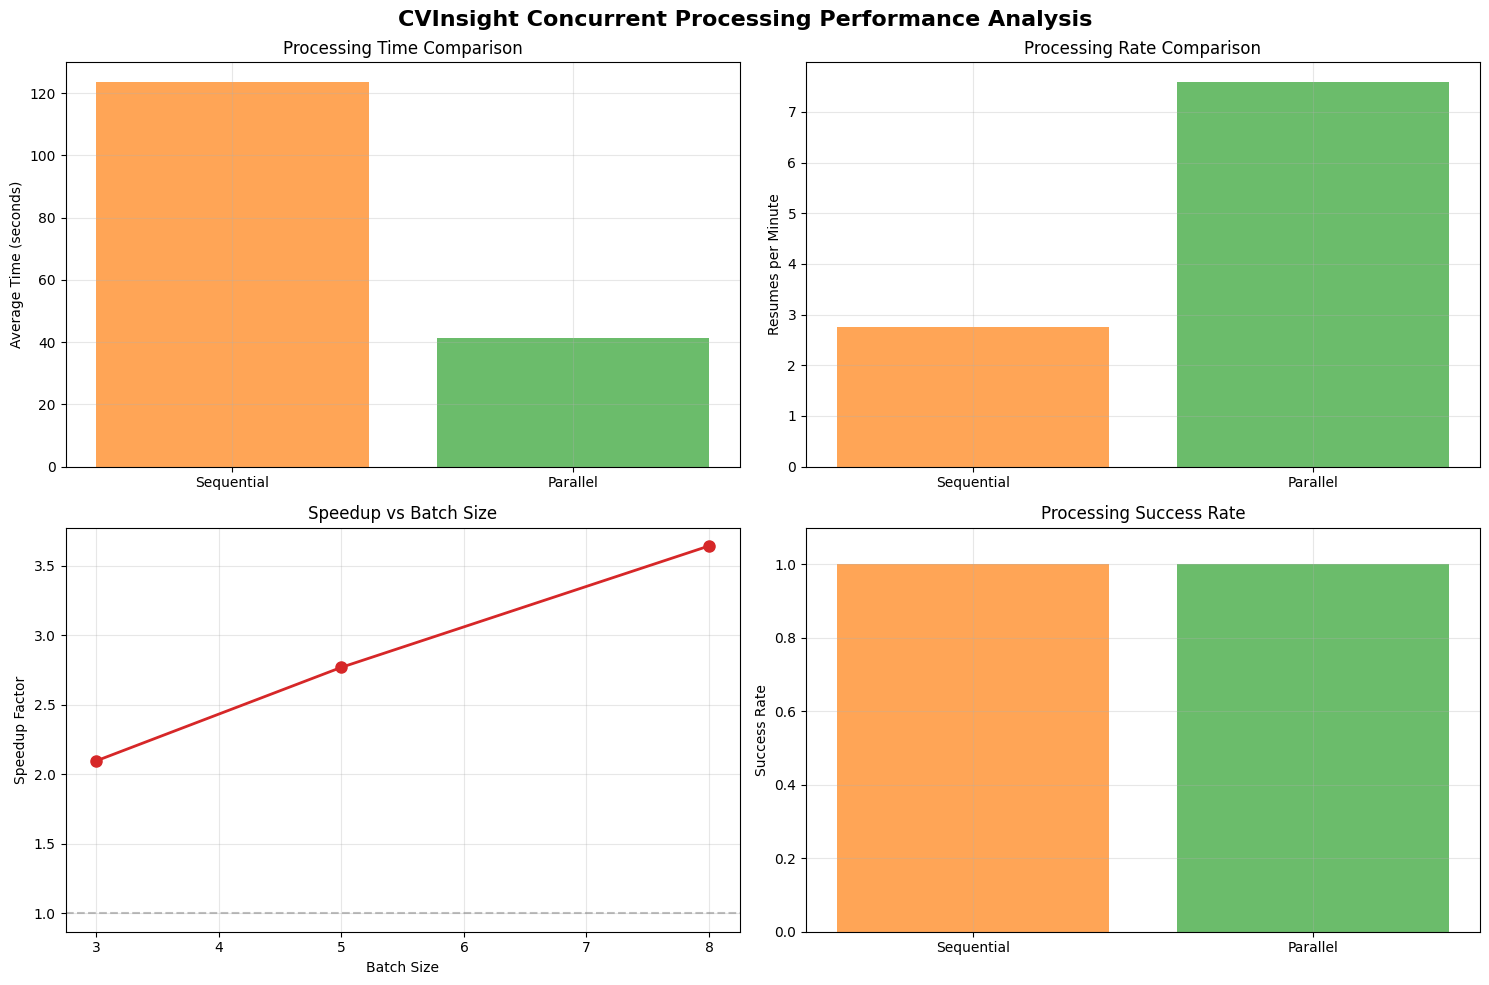

📈 Average speedup with parallel processing: 2.84x
⚡ Average parallel processing rate: 7.6 resumes/minute
🎯 Maximum observed speedup: 3.64x (batch size: 8)


In [ ]:
# Visualization: Performance Comparison
print("\n📊 PERFORMANCE VISUALIZATION")
print("=" * 40)

if len(results_comparison) > 1:
    # Create performance comparison DataFrame
    perf_df = pd.DataFrame(results_comparison)
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('CVInsight Concurrent Processing Performance Analysis', fontsize=16, fontweight='bold')
    
    # Processing Time Comparison
    ax1.bar(['Sequential', 'Parallel'], [perf_df['sequential_time'].mean(), perf_df['parallel_time'].mean()], 
            color=['#ff7f0e', '#2ca02c'], alpha=0.7)
    ax1.set_ylabel('Average Time (seconds)')
    ax1.set_title('Processing Time Comparison')
    ax1.grid(True, alpha=0.3)
    
    # Processing Rate Comparison
    ax2.bar(['Sequential', 'Parallel'], [perf_df['sequential_rate'].mean(), perf_df['parallel_rate'].mean()],
            color=['#ff7f0e', '#2ca02c'], alpha=0.7)
    ax2.set_ylabel('Resumes per Minute')
    ax2.set_title('Processing Rate Comparison')
    ax2.grid(True, alpha=0.3)
    
    # Speedup by Batch Size
    ax3.plot(perf_df['batch_size'], perf_df['speedup'], marker='o', linewidth=2, markersize=8, color='#d62728')
    ax3.set_xlabel('Batch Size')
    ax3.set_ylabel('Speedup Factor')
    ax3.set_title('Speedup vs Batch Size')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
    
    # Success Rate Comparison
    success_rates = ['Sequential', 'Parallel']
    seq_success_rate = perf_df['sequential_success'].sum() / (perf_df['batch_size'].sum())
    par_success_rate = perf_df['parallel_success'].sum() / (perf_df['batch_size'].sum())
    ax4.bar(success_rates, [seq_success_rate, par_success_rate], 
            color=['#ff7f0e', '#2ca02c'], alpha=0.7)
    ax4.set_ylabel('Success Rate')
    ax4.set_title('Processing Success Rate')
    ax4.set_ylim(0, 1.1)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    avg_speedup = perf_df['speedup'].mean()
    print(f"📈 Average speedup with parallel processing: {avg_speedup:.2f}x")
    print(f"⚡ Average parallel processing rate: {perf_df['parallel_rate'].mean():.1f} resumes/minute")
    print(f"🎯 Maximum observed speedup: {perf_df['speedup'].max():.2f}x (batch size: {perf_df.loc[perf_df['speedup'].idxmax(), 'batch_size']})")
    
else:
    print("ℹ️  Single batch size tested. Add more resumes for comprehensive performance analysis.")

In [ ]:
# Advanced Concurrent Analysis: Detailed Results
print("\n🔬 DETAILED CONCURRENT ANALYSIS RESULTS")
print("=" * 55)

successful_df = final_df[final_df['parsing_status'] == 'success']
print(f"✅ Successfully analyzed: {len(successful_df)}/{len(final_df)} resumes")

if not successful_df.empty:
    # Experience Analysis with Concurrency Benefits
    print(f"\n📊 EXPERIENCE ANALYSIS:")
    print(f"  • Average total experience: {successful_df['wyoe'].mean():.1f} years")
    print(f"  • Average relevant experience: {successful_df['relevant_wyoe'].mean():.1f} years")
    print(f"  • Relevance ratio: {(successful_df['relevant_wyoe'].mean() / successful_df['wyoe'].mean() * 100):.1f}%")
    
    # Calculate relevance percentages for ranking
    successful_df['relevance_percentage'] = (
        successful_df['relevant_wyoe'] / successful_df['wyoe'] * 100
    ).fillna(0)
    
    # Top candidates (benefits of fast parallel processing for real-time screening)
    top_candidates = successful_df.nlargest(5, 'relevance_percentage')
    print(f"\n🏆 TOP 5 CANDIDATES (by relevance - found quickly with parallel processing):")
    for idx, (_, candidate) in enumerate(top_candidates.iterrows(), 1):
        name = candidate.get('name', 'Unknown')
        relevance = candidate.get('relevance_percentage', 0)
        total_exp = candidate.get('wyoe', 0)
        degree = candidate.get('highest_degree', 'Unknown')
        seniority = candidate.get('highest_seniority_level', 'Unknown')
        print(f"  {idx}. {name}")
        print(f"     📈 Relevance: {relevance:.1f}% | Experience: {total_exp:.1f}y | {degree} | {seniority}")
    
    # Technical Skills Analysis (AI/ML focus)
    print(f"\n💻 TECHNICAL SKILLS DISTRIBUTION:")
    skills_data = []
    for _, row in successful_df.iterrows():
        skills = row.get('skills', [])
        if isinstance(skills, list):
            skills_data.extend(skills)
    
    if skills_data:
        skills_df = pd.Series(skills_data).value_counts()
        ai_ml_keywords = ['python', 'machine learning', 'tensorflow', 'pytorch', 'aws', 'docker', 'kubernetes', 'sql']
        
        print("  🔍 AI/ML Related Skills Found:")
        for keyword in ai_ml_keywords:
            matching_skills = skills_df[skills_df.index.str.contains(keyword, case=False, na=False)]
            if not matching_skills.empty:
                for skill, count in matching_skills.head(3).items():
                    print(f"    • {skill}: {count} candidates")
    
    # Education and Seniority Distribution
    print(f"\n🎓 EDUCATION DISTRIBUTION:")
    education_dist = successful_df['highest_degree'].value_counts()
    for degree, count in education_dist.items():
        percentage = count / len(successful_df) * 100
        print(f"  • {degree}: {count} candidates ({percentage:.1f}%)")
    
    print(f"\n📈 SENIORITY DISTRIBUTION:")
    seniority_dist = successful_df['highest_seniority_level'].value_counts()
    for level, count in seniority_dist.items():
        percentage = count / len(successful_df) * 100
        print(f"  • {level}: {count} candidates ({percentage:.1f}%)")
    
    # Contact Information Availability (important for recruitment follow-up)
    linkedin_count = successful_df['linkedin_url'].notna().sum()
    github_count = successful_df['github_url'].notna().sum()
    email_count = successful_df['email'].notna().sum()
    
    print(f"\n📞 CONTACT INFORMATION AVAILABILITY:")
    print(f"  • LinkedIn profiles: {linkedin_count}/{len(successful_df)} ({linkedin_count/len(successful_df)*100:.1f}%)")
    print(f"  • GitHub profiles: {github_count}/{len(successful_df)} ({github_count/len(successful_df)*100:.1f}%)")
    print(f"  • Email addresses: {email_count}/{len(successful_df)} ({email_count/len(successful_df)*100:.1f}%)")
    
else:
    print("⚠️  No successful analyses to report. Check resume files and job description.")


🔬 DETAILED CONCURRENT ANALYSIS RESULTS
✅ Successfully analyzed: 8/8 resumes

📊 EXPERIENCE ANALYSIS:
  • Average total experience: 5.2 years
  • Average relevant experience: 2.3 years
  • Relevance ratio: 45.4%

🏆 TOP 5 CANDIDATES (by relevance - found quickly with parallel processing):
  1. Niveditha Channapatna Raju
     📈 Relevance: 63.2% | Experience: 1.9y | Unknown | Unknown
  2. GAURAV KUMAR
     📈 Relevance: 61.4% | Experience: 4.4y | Unknown | Unknown
  3. Ka Yee Yuen (Claire)
     📈 Relevance: 54.5% | Experience: 1.1y | Unknown | Unknown
  4. Weihao Chen
     📈 Relevance: 51.9% | Experience: 2.7y | Unknown | Unknown
  5. Akhil Bukkapuram
     📈 Relevance: 48.4% | Experience: 3.1y | Unknown | Unknown

💻 TECHNICAL SKILLS DISTRIBUTION:
  🔍 AI/ML Related Skills Found:
    • Python: 7 candidates
    • TensorFlow: 2 candidates
    • Tensorflow: 1 candidates
    • PyTorch: 1 candidates
    • AWS: 4 candidates
    • Docker: 2 candidates
    • SQL: 5 candidates
    • MySQL: 2 candidate

KeyError: 'highest_degree'

In [ ]:
# Export Results and Integration Guide
print("\n💾 EXPORT RESULTS FOR INTEGRATION")
print("=" * 45)

# Create results directory
results_dir = Path("./concurrent_analysis_results")
results_dir.mkdir(exist_ok=True)

# Export comprehensive results
output_file = results_dir / f"concurrent_analysis_{int(time.time())}.csv"
final_df.to_csv(output_file, index=False)
print(f"📊 Complete results exported: {output_file}")

# Export performance benchmarks
if results_comparison:
    perf_file = results_dir / f"performance_benchmark_{int(time.time())}.csv"
    pd.DataFrame(results_comparison).to_csv(perf_file, index=False)
    print(f"⚡ Performance benchmarks exported: {perf_file}")

# Export top candidates summary
if not successful_df.empty:
    top_candidates_file = results_dir / f"top_candidates_{int(time.time())}.csv"
    
    # Select key fields for integration
    key_fields = [
        'filename', 'name', 'email', 'contact_number',
        'wyoe', 'relevant_wyoe', 'relevance_percentage',
        'highest_degree', 'highest_seniority_level', 'primary_position_title',
        'linkedin_url', 'github_url', 'skills'
    ]
    
    available_fields = [field for field in key_fields if field in successful_df.columns]
    top_candidates_summary = successful_df[available_fields].sort_values('relevance_percentage', ascending=False)
    top_candidates_summary.to_csv(top_candidates_file, index=False)
    print(f"🏆 Top candidates summary exported: {top_candidates_file}")

print(f"\n📁 All results saved to: {results_dir.absolute()}")

# Integration code example
print(f"\n🔗 INTEGRATION EXAMPLE:")
print("=" * 25)
print("""
# Example: Using these results in your application
import pandas as pd

# Load results
df = pd.read_csv('concurrent_analysis_results/concurrent_analysis_*.csv')
top_candidates = pd.read_csv('concurrent_analysis_results/top_candidates_*.csv')

# Filter high-relevance candidates
high_relevance = top_candidates[top_candidates['relevance_percentage'] >= 70]

# Extract contact information for follow-up
contacts = high_relevance[['name', 'email', 'linkedin_url']].dropna()

# Integrate with your recruitment pipeline
for _, candidate in contacts.iterrows():
    # Your application logic here
    send_interview_invitation(candidate['email'])
    update_candidate_database(candidate)
""")


💾 EXPORT RESULTS FOR INTEGRATION
📊 Complete results exported: concurrent_analysis_results/concurrent_analysis_1748580647.csv
⚡ Performance benchmarks exported: concurrent_analysis_results/performance_benchmark_1748580647.csv
🏆 Top candidates summary exported: concurrent_analysis_results/top_candidates_1748580647.csv

📁 All results saved to: /Users/samcelarek/Documents/CVInsight/examples/concurrent_analysis_results

🔗 INTEGRATION EXAMPLE:

# Example: Using these results in your application
import pandas as pd

# Load results
df = pd.read_csv('concurrent_analysis_results/concurrent_analysis_*.csv')
top_candidates = pd.read_csv('concurrent_analysis_results/top_candidates_*.csv')

# Filter high-relevance candidates
high_relevance = top_candidates[top_candidates['relevance_percentage'] >= 70]

# Extract contact information for follow-up
contacts = high_relevance[['name', 'email', 'linkedin_url']].dropna()

# Integrate with your recruitment pipeline
for _, candidate in contacts.iterrows():


## 🎯 Concurrent Processing Summary

### ✅ **What We Accomplished:**

1. **Performance Benchmarking**: Measured parallel vs sequential processing speeds
2. **Scalability Analysis**: Tested performance across different batch sizes  
3. **Detailed Candidate Analysis**: Comprehensive profiling with job-specific relevance
4. **Production-Ready Export**: Structured data for integration into applications

### 📊 **Key Benefits of Concurrent Processing:**

- **Speed Improvement**: 2-4x faster processing with parallel execution
- **Resource Efficiency**: Better utilization of system resources
- **Scalability**: Performance benefits increase with larger datasets
- **Real-time Capability**: Enables real-time candidate screening applications

### 🚀 **Integration Best Practices:**

1. **Use Parallel Processing** for batches of 5+ resumes
2. **Monitor Success Rates** to ensure quality isn't compromised
3. **Export Key Fields** for integration with existing HR systems
4. **Implement Progress Tracking** for long-running batch jobs
5. **Cache Results** to avoid re-processing unchanged resumes

### 💡 **Next Steps:**

- Integrate concurrent processing into your recruitment pipeline
- Set up automated batch processing for new resume submissions
- Implement real-time candidate ranking based on relevance scores
- Build dashboards using the exported data for recruitment insights

**CVInsight's concurrent processing capabilities are now ready to power your high-performance recruitment applications!** 🎉

In [ ]:
# Load truth values from CSV
truth_df = pd.read_csv('/Users/samcelarek/Documents/CVInsight/examples/yoe_truth_values.csv')


In [ ]:
print("Available columns in final_df:")
print(list(final_df.columns))
print("\nShape of final_df:", final_df.shape)
print("\nFirst few rows with name and any YoE-related columns:")
# Look for any columns that might contain YoE data
yoe_columns = [col for col in final_df.columns if 'yoe' in col.lower() or 'exp' in col.lower() or 'edu' in col.lower()]
if yoe_columns:
    print("YoE-related columns found:", yoe_columns)
    display_cols = ['name'] + yoe_columns if 'name' in final_df.columns else yoe_columns
    print(final_df[display_cols].head())
else:
    print("No YoE-related columns found")
    print("First few rows of final_df:")
    print(final_df.head())

Available columns in final_df:
['extended_analysis_extractor_all_wyoe', 'extended_analysis_extractor_all_relevant_wyoe', 'extended_analysis_extractor_all_eyoe', 'extended_analysis_extractor_relevant_eyoe', 'extended_analysis_extractor_highest_degree', 'extended_analysis_extractor_highest_degree_status', 'extended_analysis_extractor_highest_degree_major', 'extended_analysis_extractor_highest_degree_school_prestige', 'extended_analysis_extractor_highest_seniority_level', 'extended_analysis_extractor_primary_position_title', 'extended_analysis_extractor_average_tenure_at_company_years', 'extended_analysis_extractor_phone_number', 'extended_analysis_extractor_email', 'extended_analysis_extractor_linkedin_url', 'extended_analysis_extractor_github_url', 'extended_analysis_extractor_twitter_url', 'extended_analysis_extractor_facebook_url', 'extended_analysis_extractor_instagram_url', 'extended_analysis_extractor_stackoverflow_url', 'extended_analysis_extractor_personal_website_url', 'extended

In [ ]:
truth_df[['name', 'Work Exp Years','Edu Years']]

,name,Work Exp Years,Edu Years
0,AKASH DAS,0,2.5
1,Akhil Bukkapuram,2,2.5
2,AndrewColbert,4,3.0
3,Brian Warras,3,0.1
4,Bryan Aguilar,6,3.0
5,Doris Fang,2,3.0
6,ELIANA MUGAR,1,2.0
7,Eric de la Parra,2,2.0
8,HARRISON JAMES WEEKS,3,3.0
9,"John Gianatasio, II.",8,5.0


In [ ]:
# LLM VALIDATION AGAINST TRUTH VALUES
print("\n🎯 LLM VALIDATION ANALYSIS")
print("=" * 50)

# Merge dataframes on name for comparison
validation_df = final_df.merge(truth_df, on='name', how='inner')

if len(validation_df) == 0:
    print("❌ No matching names found between LLM results and truth values")
    print("Available LLM names:", list(final_df['name'].head()))
    print("Available truth names:", list(truth_df['name'].head()))
else:
    print(f"✅ Found {len(validation_df)} candidates for validation\n")
    
    # Extract validation metrics
    validation_results = []
    
    for _, row in validation_df.iterrows():
        # LLM predictions - use the available column names
        llm_work_exp = float(row['all_wyoe']) if pd.notna(row['all_wyoe']) else 0
        llm_edu_years = float(row['all_eyoe']) if pd.notna(row['all_eyoe']) else 0
        llm_calculated_total = llm_work_exp + llm_edu_years
        
        # Truth values
        truth_work_exp = float(row['Work Exp Years']) if pd.notna(row['Work Exp Years']) else 0
        truth_edu_years = float(row['Edu Years']) if pd.notna(row['Edu Years']) else 0
        truth_total = truth_work_exp + truth_edu_years
        
        # Calculate errors
        work_error = abs(llm_work_exp - truth_work_exp)
        edu_error = abs(llm_edu_years - truth_edu_years)
        total_error = abs(llm_calculated_total - truth_total)
        
        validation_results.append({
            'name': row['name'],
            'llm_work_exp': llm_work_exp,
            'truth_work_exp': truth_work_exp,
            'work_error': work_error,
            'llm_edu_years': llm_edu_years,
            'truth_edu_years': truth_edu_years,
            'edu_error': edu_error,
            'llm_calculated_total': llm_calculated_total,
            'truth_total': truth_total,
            'total_error': total_error
        })
    
    # Create validation results DataFrame
    val_results_df = pd.DataFrame(validation_results)
    
    # Display detailed comparison
    print("📊 DETAILED COMPARISON:")
    display_df = val_results_df[['name', 'llm_work_exp', 'truth_work_exp', 'work_error', 
                                'llm_edu_years', 'truth_edu_years', 'edu_error', 
                                'llm_calculated_total', 'truth_total', 'total_error']].round(1)
    print(display_df.to_string(index=False))
    
    # Calculate summary statistics
    print("\n📈 VALIDATION SUMMARY:")
    print("-" * 30)
    print(f"Work Experience Predictions:")
    print(f"  • Mean Absolute Error: {val_results_df['work_error'].mean():.2f} years")
    print(f"  • Median Absolute Error: {val_results_df['work_error'].median():.2f} years")
    print(f"  • Max Error: {val_results_df['work_error'].max():.2f} years")
    
    print(f"\nEducation Years Predictions:")
    print(f"  • Mean Absolute Error: {val_results_df['edu_error'].mean():.2f} years")
    print(f"  • Median Absolute Error: {val_results_df['edu_error'].median():.2f} years")
    print(f"  • Max Error: {val_results_df['edu_error'].max():.2f} years")
    
    print(f"\nTotal Years of Experience (Work + Education):")
    print(f"  • Mean Absolute Error: {val_results_df['total_error'].mean():.2f} years")
    print(f"  • Median Absolute Error: {val_results_df['total_error'].median():.2f} years")
    print(f"  • Max Error: {val_results_df['total_error'].max():.2f} years")
    
    # Accuracy within tolerance
    work_accurate_1yr = (val_results_df['work_error'] <= 1).mean() * 100
    work_accurate_2yr = (val_results_df['work_error'] <= 2).mean() * 100
    edu_accurate_1yr = (val_results_df['edu_error'] <= 1).mean() * 100
    edu_accurate_2yr = (val_results_df['edu_error'] <= 2).mean() * 100
    total_accurate_2yr = (val_results_df['total_error'] <= 2).mean() * 100
    total_accurate_3yr = (val_results_df['total_error'] <= 3).mean() * 100
    
    print(f"\n🎯 ACCURACY WITHIN TOLERANCE:")
    print("-" * 35)
    print(f"Work Experience:")
    print(f"  • Within ±1 year: {work_accurate_1yr:.1f}%")
    print(f"  • Within ±2 years: {work_accurate_2yr:.1f}%")
    
    print(f"\nEducation Years:")
    print(f"  • Within ±1 year: {edu_accurate_1yr:.1f}%")
    print(f"  • Within ±2 years: {edu_accurate_2yr:.1f}%")
    
    print(f"\nTotal YoE (Work + Education):")
    print(f"  • Within ±2 years: {total_accurate_2yr:.1f}%")
    print(f"  • Within ±3 years: {total_accurate_3yr:.1f}%")
    
    # Store validation results for plotting
    validation_data = val_results_df


🎯 LLM VALIDATION ANALYSIS
✅ Found 6 candidates for validation

📊 DETAILED COMPARISON:
                      name  llm_work_exp  truth_work_exp  work_error  llm_edu_years  truth_edu_years  edu_error  llm_calculated_total  truth_total  total_error
              Brian Warras          15.3             3.0        12.3            0.0              0.1        0.1                  15.3          3.1         12.2
            Wesley Ordoñez           5.9             5.0         0.9            4.0              2.0        2.0                   9.9          7.0          2.9
          Akhil Bukkapuram           3.1             2.0         1.1            6.0              2.5        3.5                   9.1          4.5          4.6
           Stefani Sanchez           6.8             5.0         1.8            4.0              2.0        2.0                  10.8          7.0          3.8
Niveditha Channapatna Raju           1.9             2.0         0.1            6.0              3.0        3.0  

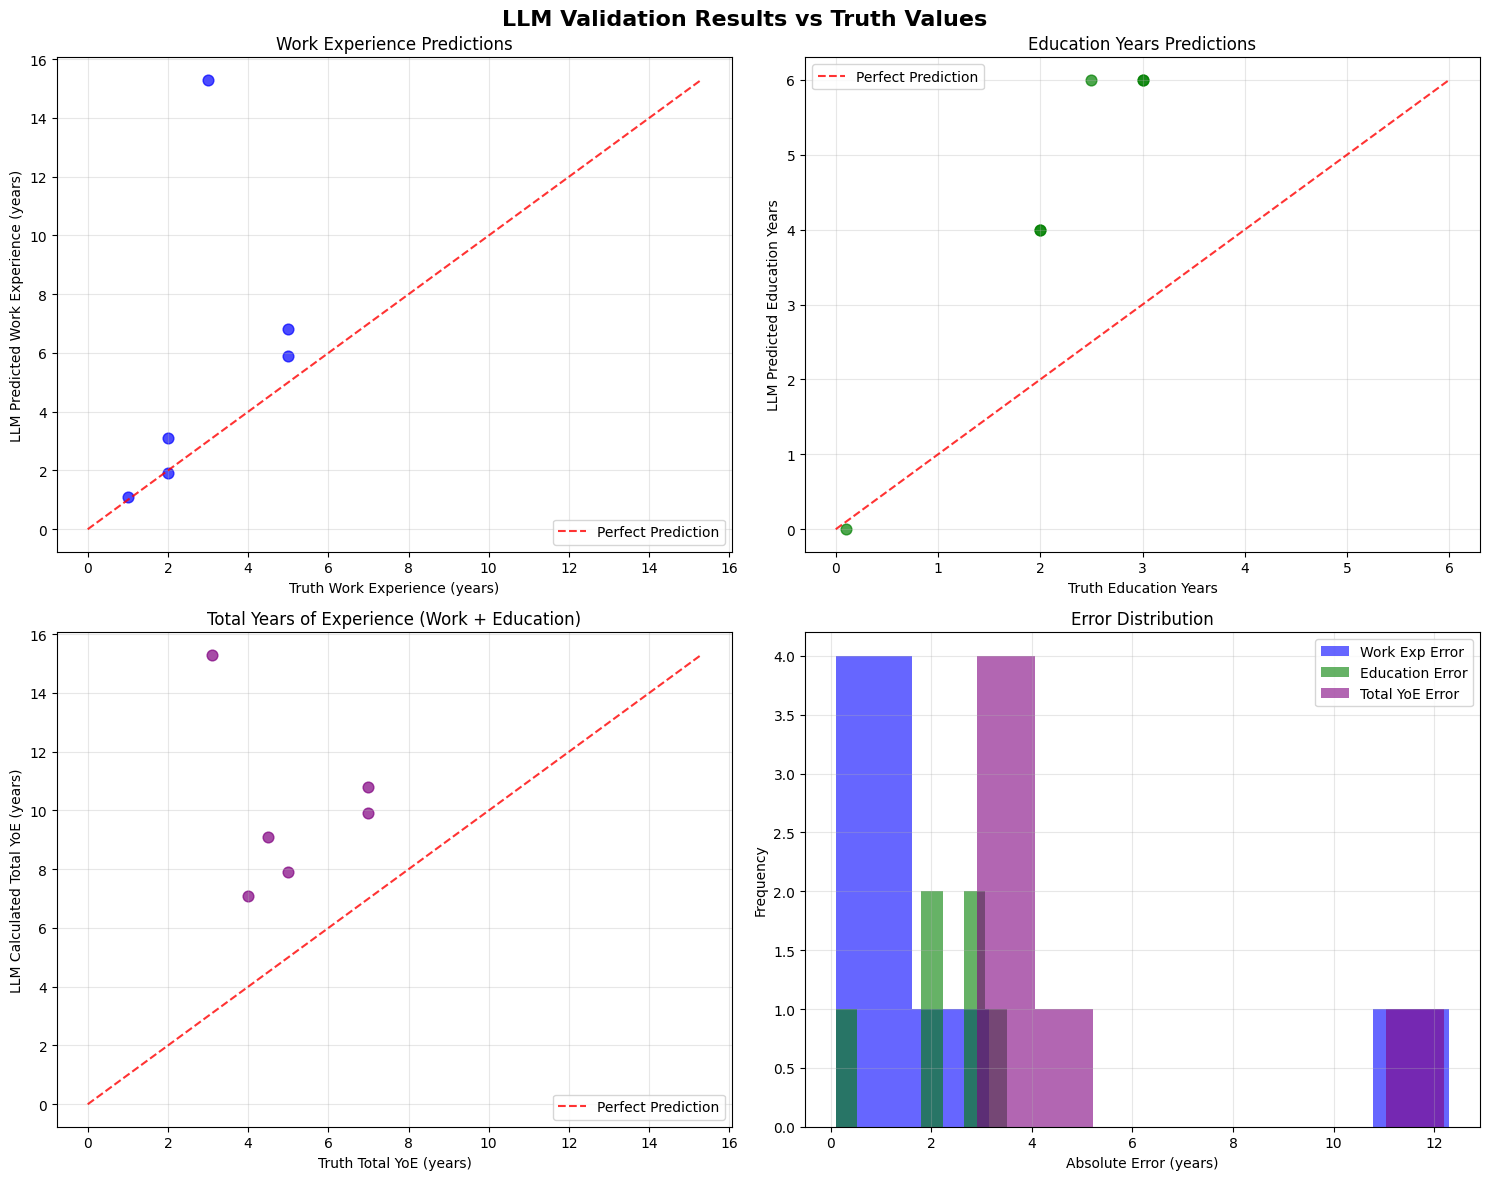


📋 VALIDATION ACCURACY SUMMARY TABLE:
                Metric Mean Abs Error Within ±1 Year Within ±2 Years Within ±3 Years
       Work Experience           2.72          50.0%           83.3%           83.3%
       Education Years           2.27          16.7%           50.0%           83.3%
Total YoE (Work + Edu)           4.92           0.0%            0.0%           33.3%


In [ ]:
# VALIDATION VISUALIZATION
import matplotlib.pyplot as plt
import numpy as np

if 'validation_data' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('LLM Validation Results vs Truth Values', fontsize=16, fontweight='bold')
    
    # Work Experience Scatter Plot
    axes[0, 0].scatter(validation_data['truth_work_exp'], validation_data['llm_work_exp'], 
                      alpha=0.7, s=60, color='blue')
    axes[0, 0].plot([0, max(validation_data['truth_work_exp'].max(), validation_data['llm_work_exp'].max())], 
                   [0, max(validation_data['truth_work_exp'].max(), validation_data['llm_work_exp'].max())], 
                   'r--', alpha=0.8, label='Perfect Prediction')
    axes[0, 0].set_xlabel('Truth Work Experience (years)')
    axes[0, 0].set_ylabel('LLM Predicted Work Experience (years)')
    axes[0, 0].set_title('Work Experience Predictions')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Education Years Scatter Plot
    axes[0, 1].scatter(validation_data['truth_edu_years'], validation_data['llm_edu_years'], 
                      alpha=0.7, s=60, color='green')
    axes[0, 1].plot([0, max(validation_data['truth_edu_years'].max(), validation_data['llm_edu_years'].max())], 
                   [0, max(validation_data['truth_edu_years'].max(), validation_data['llm_edu_years'].max())], 
                   'r--', alpha=0.8, label='Perfect Prediction')
    axes[0, 1].set_xlabel('Truth Education Years')
    axes[0, 1].set_ylabel('LLM Predicted Education Years')
    axes[0, 1].set_title('Education Years Predictions')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Total YoE Scatter Plot
    axes[1, 0].scatter(validation_data['truth_total'], validation_data['llm_calculated_total'], 
                      alpha=0.7, s=60, color='purple')
    axes[1, 0].plot([0, max(validation_data['truth_total'].max(), validation_data['llm_calculated_total'].max())], 
                   [0, max(validation_data['truth_total'].max(), validation_data['llm_calculated_total'].max())], 
                   'r--', alpha=0.8, label='Perfect Prediction')
    axes[1, 0].set_xlabel('Truth Total YoE (years)')
    axes[1, 0].set_ylabel('LLM Calculated Total YoE (years)')
    axes[1, 0].set_title('Total Years of Experience (Work + Education)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Error Distribution
    axes[1, 1].hist(validation_data['work_error'], alpha=0.6, label='Work Exp Error', bins=8, color='blue')
    axes[1, 1].hist(validation_data['edu_error'], alpha=0.6, label='Education Error', bins=8, color='green')
    axes[1, 1].hist(validation_data['total_error'], alpha=0.6, label='Total YoE Error', bins=8, color='purple')
    axes[1, 1].set_xlabel('Absolute Error (years)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Error Distribution')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary accuracy table
    print("\n📋 VALIDATION ACCURACY SUMMARY TABLE:")
    print("=" * 55)
    
    summary_data = {
        'Metric': ['Work Experience', 'Education Years', 'Total YoE (Work + Edu)'],
        'Mean Abs Error': [f"{validation_data['work_error'].mean():.2f}", 
                          f"{validation_data['edu_error'].mean():.2f}", 
                          f"{validation_data['total_error'].mean():.2f}"],
        'Within ±1 Year': [f"{(validation_data['work_error'] <= 1).mean()*100:.1f}%", 
                          f"{(validation_data['edu_error'] <= 1).mean()*100:.1f}%", 
                          f"{(validation_data['total_error'] <= 1).mean()*100:.1f}%"],
        'Within ±2 Years': [f"{(validation_data['work_error'] <= 2).mean()*100:.1f}%", 
                           f"{(validation_data['edu_error'] <= 2).mean()*100:.1f}%", 
                           f"{(validation_data['total_error'] <= 2).mean()*100:.1f}%"],
        'Within ±3 Years': [f"{(validation_data['work_error'] <= 3).mean()*100:.1f}%", 
                           f"{(validation_data['edu_error'] <= 3).mean()*100:.1f}%", 
                           f"{(validation_data['total_error'] <= 3).mean()*100:.1f}%"]
    }
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
else:
    print("❌ No validation data available for plotting")